Preprocessing based on suggestions from Google Gemini

based on https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

and https://www.10xgenomics.com/analysis-guides/common-considerations-for-quality-control-filters-for-single-cell-rna-seq-data

Code in this notebook primarily generated using Gemini 3.0

In [1]:
import anndata as ad
import dask.array as da
import h5py
import numpy as np
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

datadir = Path('/Users/poldrack/data_unsynced/BCBS/ad_scrnaseq/')

In [2]:
adata = ad.read_h5ad(datadir / 'glia_subset.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 129930 × 33389
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_counts'
    uns: 'ADNC_colors', 'APOE4 status_colors', 'Age at 

In [106]:
adata.obs['Braak stage'].value_counts()

Braak stage
Braak V      51332
Braak IV     30920
Braak VI     22304
Braak III     7803
Braak II      5855
Reference     4725
Braak 0       3815
Name: count, dtype: int64

### Quality control

based on https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html


In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var['feature_name'].str.startswith("MT-")
print(f"Number of mitochondrial genes: {adata.var['mt'].sum()}")

# ribosomal genes
adata.var["ribo"] = adata.var['feature_name'].str.startswith(("RPS", "RPL"))
print(f"Number of ribosomal genes: {adata.var['ribo'].sum()}")

# hemoglobin genes.
adata.var["hb"] = adata.var['feature_name'].str.contains("^HB[^(P)]")
print(f"Number of hemoglobin genes: {adata.var['hb'].sum()}")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)



Number of mitochondrial genes: 13
Number of ribosomal genes: 106
Number of hemoglobin genes: 12


Visualization of distributions 

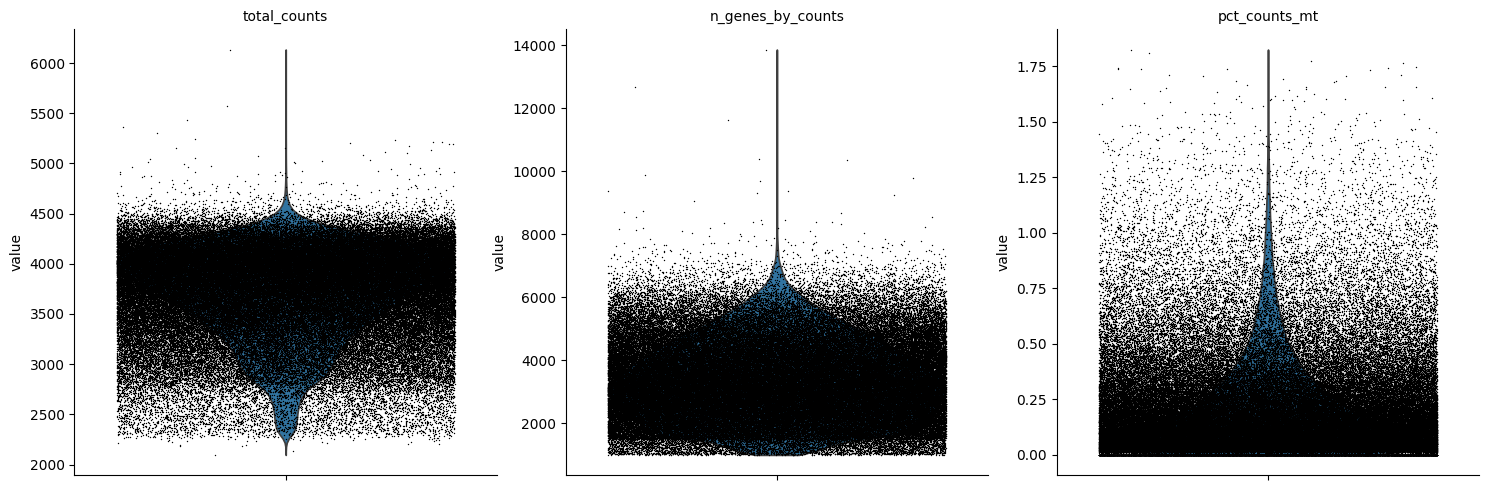

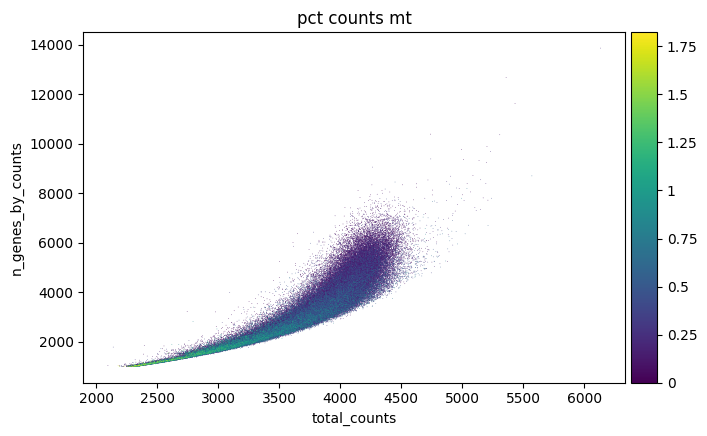

In [4]:

# 1. Violin plots to see the distribution of QC metrics
# Note: I am using the exact column names from your adata output
p1 = sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# 2. Scatter plot to spot doublets and dying cells
# High mito + low genes = dying cell
# High counts + high genes = potential doublet
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [5]:
# Create a copy or view to avoid modifying the original if needed
adata_qc = adata.copy()

# 1. Filter based on mitochondrial fraction - 10% doesn't seem to lose any cells
adata_qc = adata_qc[adata_qc.obs['Fraction mitochrondrial UMIs'] < 0.1, :]
n_obs_after_mito_filter = adata_qc.n_obs
print(f'Dropped {adata.n_obs - adata_qc.n_obs} cells based on mitochondrial fraction')

# 2. Filter based on Genes detected (Min 200, Max 7000)
adata_qc = adata_qc[adata_qc.obs['Genes detected'] > 200, :]
adata_qc = adata_qc[adata_qc.obs['Genes detected'] < 7000, :]
n_obs_after_gene_filter = adata_qc.n_obs
print(f'Dropped {n_obs_after_mito_filter - n_obs_after_gene_filter} cells based on gene detection')

# 3. (Optional) Filter based on UMI counts
# Usually gene filtering covers this, but you can remove extreme outliers
adata_qc = adata_qc[adata_qc.obs['Number of UMIs'] < 30000, :]
n_obs_after_umi_filter = adata_qc.n_obs
print(f'Dropped {n_obs_after_gene_filter - n_obs_after_umi_filter} cells based on UMI counts')

print(f"Original cells: {adata.n_obs}")
print(f"Cells after QC: {adata_qc.n_obs}")

Dropped 0 cells based on mitochondrial fraction
Dropped 326 cells based on gene detection
Dropped 1096 cells based on UMI counts
Original cells: 129930
Cells after QC: 128508


perform doublet detection
- first need to filter out small batches

In [6]:
# Check the number of cells per Specimen ID
batch_counts = adata.obs['Specimen ID'].value_counts()

# Look at the smallest batches
print("Smallest batches:")
print(batch_counts.tail(10))

Smallest batches:
Specimen ID
M2XM_220302_222-R_A01    160
M1TX_211012_151_A01      158
M2XM_220207_216-R_B01    151
M2XM_220221_211-R_C01    144
M2XM_220222_206-R_C01    144
M2XM_220221_211-R_B01    140
M1TX_211012_151_B01      120
M2XM_220222_206-R_A01     75
M2TX_210511_203_G01        7
M2TX_210824_431_A01        1
Name: count, dtype: int64


In [7]:
# Define a minimum threshold (e.g., 50 cells)
min_cells = 50

# Identify batches to keep
valid_batches = batch_counts[batch_counts >= min_cells].index

# Filter the AnnData object
adata_filtered = adata[adata.obs['Specimen ID'].isin(valid_batches)].copy()

print(f"Original cells: {adata.n_obs}")
print(f"Cells after removing small batches: {adata_filtered.n_obs}")

Original cells: 129930
Cells after removing small batches: 129922


In [8]:
# this just adds the doublet scores to the adata.obs
sc.pp.scrublet(adata_filtered, batch_key='Specimen ID', expected_doublet_rate=0.06)


In [9]:
print(adata_filtered.obs['doublet_score'])

CCTCACAGTTTGTTGG-L8TX_211124_01_D03-1144726144    0.038068
TAGCACACAGGACAGT-L8TX_210812_01_A11-1124416554    0.019699
CTAAGTGTCACCTGTC-L8TX_210617_01_C12-1113634358    0.046377
GTCACTCGTTGTCTAG-L8TX_210902_01_E09-1129993892    0.134638
ATCAGGTAGCACACAG-L8TX_210826_01_H06-1127603900    0.093248
                                                    ...   
GTAGTACAGAGCCCAA-L8TX_210826_01_G06-1127603907    0.097889
ATCGATGTCGCCAACG-L8TX_210923_01_A08-1131758239    0.044068
CCTCCAATCCGATCTC-L8TX_210916_01_E04-1131593674    0.051873
GGTCACGTCTCGAGTA-L8TX_211028_01_C05-1140206518    0.069965
GTCGCGATCGTGCATA-L8TX_210826_01_H06-1127603900    0.057826
Name: doublet_score, Length: 129922, dtype: float64


visualize doublets



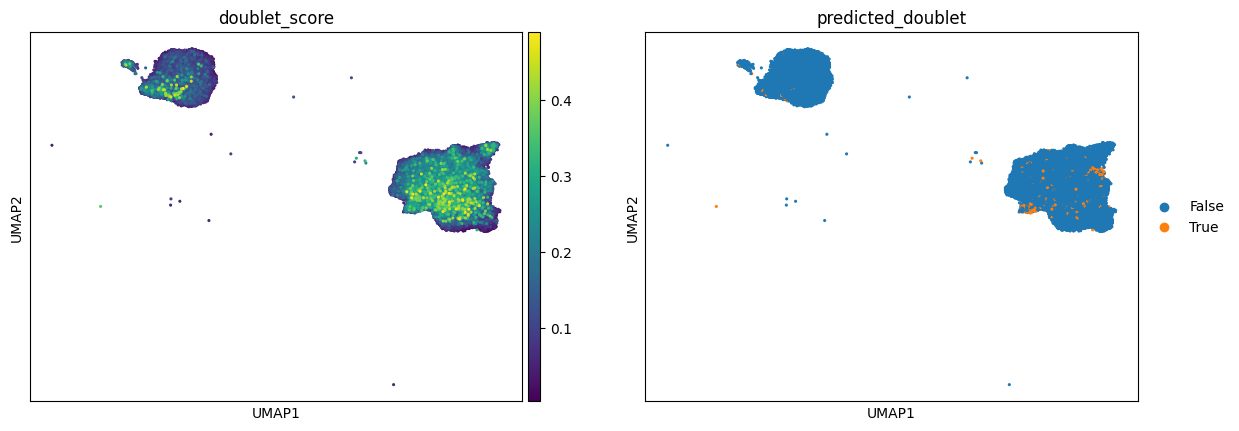

In [10]:
sc.pl.umap(adata_filtered, color=['doublet_score', 'predicted_doublet'], size=20)


filter doublets
- how consistent are these results with other methods for doublet detection? https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#doublet-detection

In [11]:
# Check how many doublets were found
print(f'found {adata_filtered.obs["predicted_doublet"].sum()} predicted doublets')

# Filter the data to keep only singlets (False)
# write back to adata for simplicity
adata = adata_filtered[adata_filtered.obs['predicted_doublet'] == False, :]

print(f"Remaining cells: {adata.n_obs}")

found 3168 predicted doublets
Remaining cells: 126754


In [12]:
#  set the .raw attribute (standard Scanpy convention)
adata.raw = adata

#### Total Count Normalization
This scales each cell so that they all have the same total number of counts (default is often 10,000, known as "CP10k").

In [13]:
# Normalize to 10,000 reads per cell
# target_sum=1e4 is the standard for 10x data
sc.pp.normalize_total(adata, target_sum=1e4)

#### Log Transformation (Log1p)
This applies a natural logarithm to the data:  log(X+1). This reduces the skewness of the data (since gene expression follows a power law) and stabilizes the variance.

In [14]:
# Logarithmically transform the data
sc.pp.log1p(adata)

#### select high-variance features

First let's plot variablility across genes

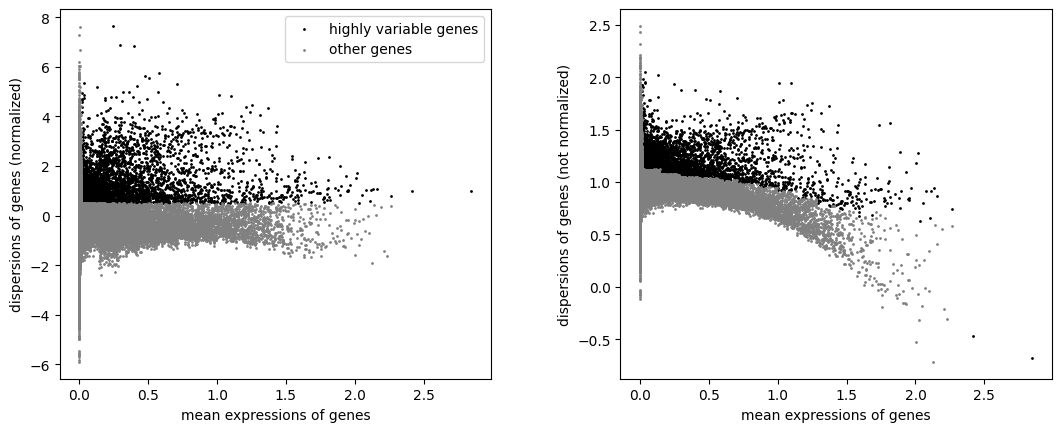

In [15]:
# Identify highly variable genes
# 'seurat' flavor is the standard default
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot to see the dispersion
sc.pl.highly_variable_genes(adata)

# (Optional) Retain only the variable genes for downstream analysis (PCA/UMAP)
# This creates a smaller view of the data for speed
adata_hvg = adata[:, adata.var['highly_variable']]

In [16]:
adata_hvg


View of AnnData object with n_obs × n_vars = 126754 × 4587
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'to

### Dimensionality reduction

In [17]:
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)

/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 4587 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


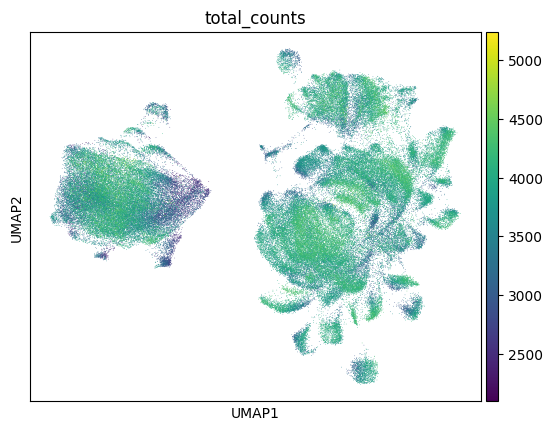

In [18]:
sc.pl.umap(adata_hvg, color="total_counts")


### Clustering


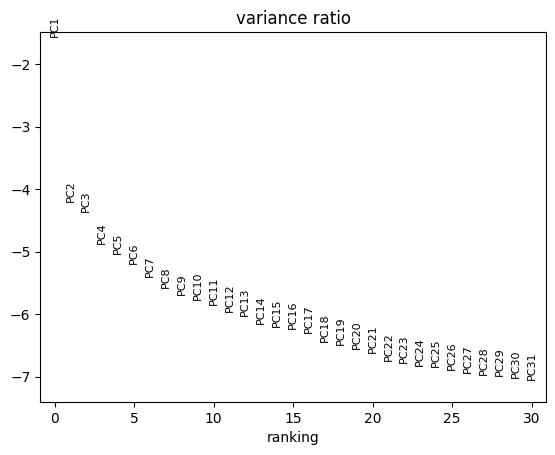

In [19]:
# Compute PCA
sc.tl.pca(adata_hvg, svd_solver='arpack')

# (Optional) Visualize variance explained by each PC
# This helps decide how many PCs to use. The "elbow" usually flattens around 10-20.
sc.pl.pca_variance_ratio(adata_hvg, log=True)

In [20]:
# Run Leiden clustering
# This adds a 'leiden' column to adata.obs
sc.tl.leiden(adata_hvg, resolution=0.5)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_70584/1212141890.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.5)


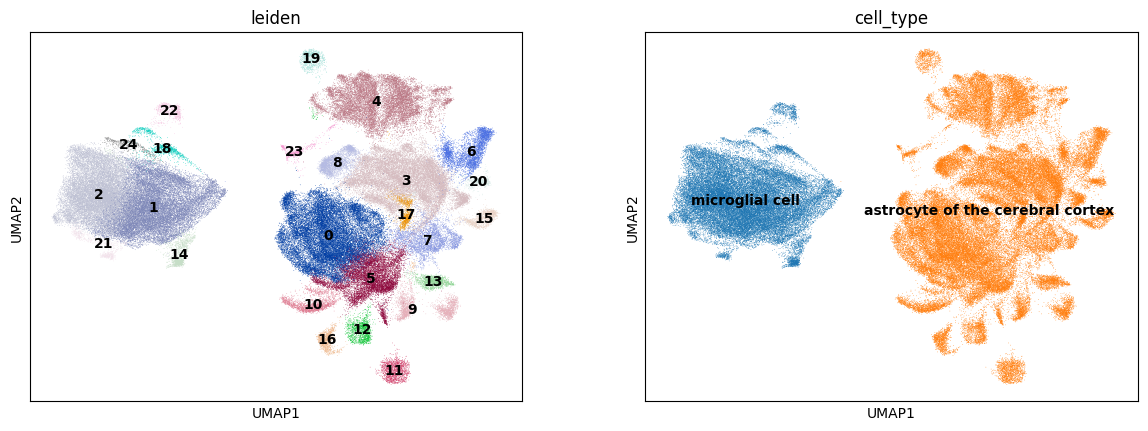

In [21]:
# Plot UMAP with Leiden clusters
sc.pl.umap(adata_hvg, color=['leiden', 'cell_type'], legend_loc='on data')

In [22]:
# drop individuals with development stage of "80 year-old and over stage"

adata_hvg = adata_hvg[adata_hvg.obs['development_stage'] != "80 year-old and over stage"].copy()

In [23]:
adata_hvg.obs['development_stage'].value_counts()

development_stage
81-year-old stage    6163
83-year-old stage    5758
88-year-old stage    5203
82-year-old stage    5133
75-year-old stage    4368
89-year-old stage    3946
86-year-old stage    3835
87-year-old stage    3226
80-year-old stage    3161
69-year-old stage    2736
78-year-old stage    2427
72-year-old stage    2047
84-year-old stage    1847
50-year-old stage    1707
29-year-old stage    1602
68-year-old stage    1435
42-year-old stage    1416
70-year-old stage    1109
85-year-old stage     811
77-year-old stage     724
Name: count, dtype: int64

In [24]:
adata_hvg.obs['age_group'] = adata_hvg.obs['development_stage'].astype(str).str.extract('(\d+)').astype(int)
adata_hvg.obs['age_group'].value_counts()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_70584/2428158716.py:1: SyntaxWarning: invalid escape sequence '\d'
  adata_hvg.obs['age_group'] = adata_hvg.obs['development_stage'].astype(str).str.extract('(\d+)').astype(int)


age_group
81    6163
83    5758
88    5203
82    5133
75    4368
89    3946
86    3835
87    3226
80    3161
69    2736
78    2427
72    2047
84    1847
50    1707
29    1602
68    1435
42    1416
70    1109
85     811
77     724
Name: count, dtype: int64

Replace ENS labels with gene names for ease of use

In [25]:

# 1. (Optional) Save the current Ensembl IDs to a new column so you don't lose them
adata_hvg.var['ensembl_id'] = adata_hvg.var_names

# 2. Set the gene symbols as the new index
# We use .astype(str) to ensure they are treated as text
adata_hvg.var_names = adata_hvg.var['feature_name'].astype(str)

# 3. Ensure the new names are unique
# This appends a suffix (e.g., '-1') to any duplicate gene names
adata_hvg.var_names_make_unique()

# Verify the change
print(adata_hvg.var_names[:5])

Index(['FIRRM', 'FGR', 'CFH', 'CFTR', 'LAP3'], dtype='object', name='feature_name')


In [ ]:
### Differential expression


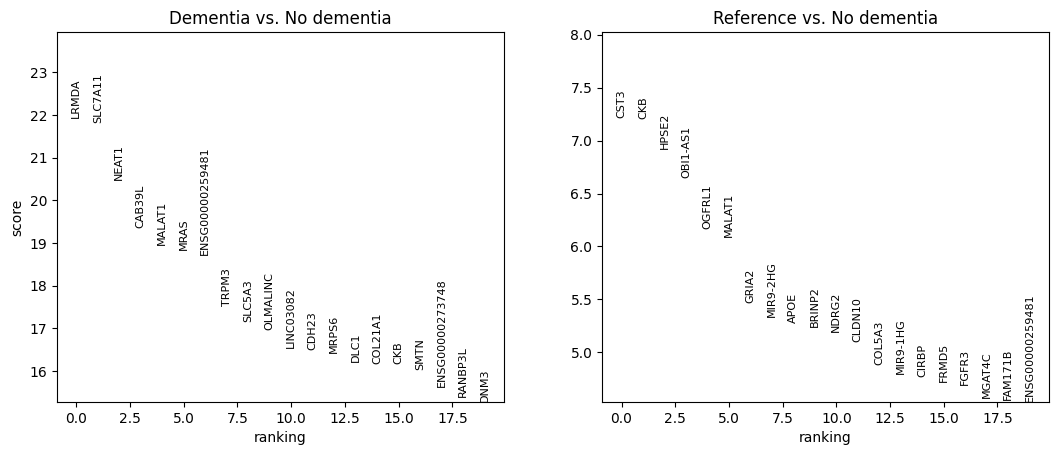

             names     scores  logfoldchanges          pvals      pvals_adj  \
0  ENSG00000148655  21.945333        1.418953  9.596347e-107  1.281650e-103   
1  ENSG00000151012  21.826395        0.553919  1.303032e-105  1.611368e-102   
2  ENSG00000245532  20.493479        0.121720   2.461613e-93   2.162915e-90   
3  ENSG00000102547  19.357334        0.823570   1.767992e-83   1.311811e-80   
4  ENSG00000251562  18.953377        0.088232   4.141383e-80   2.711306e-77   
5  ENSG00000158186  18.834421        0.627369   3.944100e-79   2.438696e-76   
6  ENSG00000259481  18.718952        0.895761   3.469127e-78   2.106012e-75   
7  ENSG00000083067  17.528713        0.462992   8.650611e-69   4.376292e-66   
8  ENSG00000198743  17.149014        0.990561   6.392797e-66   3.006325e-63   
9  ENSG00000235823  16.967937        0.933872   1.418281e-64   6.399321e-62   

        ensembl_id  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
5   

In [26]:
# differnetial expression

# 1. Subset to the cluster of interest
subset = adata_hvg[adata_hvg.obs['leiden'] == '3'].copy()

# 2. Run Rank Genes Groups (Differential Expression)
# Compare 'Dementia' vs 'No dementia' (adjust exact labels based on your Step 1 output)
sc.tl.rank_genes_groups(subset, groupby='Cognitive status', reference='No dementia', method='wilcoxon')

# 3. View the top upregulated genes in Dementia for this cluster
sc.pl.rank_genes_groups(subset, n_genes=20, sharey=False,
    gene_symbols='feature_name')

# 4. Get the table of results
de_results = sc.get.rank_genes_groups_df(subset, group='Dementia', gene_symbols='ensembl_id')
print(de_results.head(10))

### pathway enrichment

- what pathways are enriched for healthy vs demented?

In [27]:
print(adata_hvg)

AnnData object with n_obs × n_vars = 58654 × 4587
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_count

### Clustering genes

find sets of genes that move together across samples

see: https://aistudio.google.com/app/prompts?state=%7B%22ids%22:%5B%221aA_hN3GkkcSFqzGJESR5YAv6cp0bJXMe%22%5D,%22action%22:%22open%22,%22userId%22:%22102042762597626922038%22,%22resourceKeys%22:%7B%7D%7D&usp=sharing


In [28]:
from scipy import sparse

# we need this because scanpy uses sparse matrices
def sparse_corr(X):
    """
    Compute Pearson correlation matrix for a sparse matrix X.
    X: sparse matrix of shape (n_cells, n_genes)
    Returns: dense correlation matrix (n_genes, n_genes)
    """
    n = X.shape[0]

    # 1. Calculate Mean and Standard Deviation for each gene
    # .A1 converts matrix result to 1D numpy array
    sums = np.array(X.sum(axis=0)).flatten() 
    sum_sq = np.array(X.power(2).sum(axis=0)).flatten()
    
    # Calculate Variance: E[x^2] - (E[x])^2
    # We multiply by n to match the denominator of covariance later
    # var = (sum_sq - (sums^2)/n) / (n-1)
    # But we just need the numerator part for normalization first
    
    # Calculate Stds (sample std dev)
    var = (sum_sq - (sums**2) / n) / (n - 1)
    
    # Handle constant genes (variance = 0) to avoid division by zero
    var[var <= 0] = 1e-9
    stds = np.sqrt(var)

    # 2. Calculate Covariance Numerator
    # Formula: sum(x*y) - n * mean_x * mean_y
    # Efficient sparse matrix multiplication
    XtX = (X.T @ X).toarray() 
    
    # Calculate the correction term (n * mean_x * mean_y)
    # equivalent to: (sum_x * sum_y) / n
    correction = np.outer(sums, sums) / n
    
    cov_numerator = XtX - correction

    # 3. Calculate Correlation
    # corr = cov / (std_x * std_y * (n-1))
    denominator = np.outer(stds, stds) * (n - 1)
    
    corr = cov_numerator / denominator

    # Clip values to [-1, 1] to handle floating point errors
    return np.clip(corr, -1, 1)

In [29]:
import scipy.cluster.hierarchy as sch

# compute correlation across columns of the data matrix
gene_corr = sparse_corr(adata_hvg.X)



<Axes: ylabel='Count'>

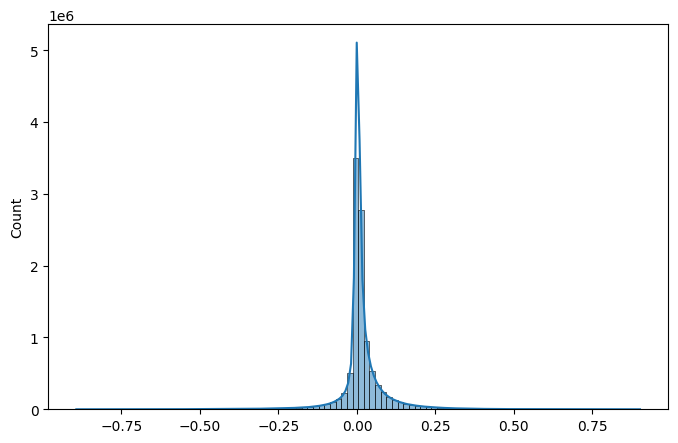

In [56]:
# plot a histogram of the correlations
plt.figure(figsize=(8, 5))
sns.histplot(gene_corr[np.triu_indices_from(gene_corr, k=1)].flatten(), bins=100, kde=True)

In [58]:
def create_adjmtx_pernode(m, density, use_abs_corr=True,
    zero_tril=True, zero_diag=True):
    """
    Create adjacency matrix for specified graph density based on functional connectivity.
    density is computed per node to prevent isolated nodes.

    Parameters:
    -----------
    m : numpy.ndarray
        Functional connectivity matrix (n_nodes x n_nodes)
        NOTE: this must be a symmetric matrix
    density : float
        Desired graph density (between 0 and 1)
    use_abs_corr : bool, optional
        Whether to use absolute correlation values. Default is True.
    zero_tril : bool, optional
        Whether to zero out the lower triangular part of the matrix. Default is True.
    zero_diag : bool, optional
        Whether to zero out the diagonal of the matrix. Default is True.    

    Returns:
    --------
    connection_matrix : numpy.ndarray
        Binary connection matrix (n_nodes x n_nodes) with specified density for each node
    """
    n_nodes = m.shape[0]
    # Process each density

    if use_abs_corr:
        m = np.abs(m)
    
    # Preallocate connection matrix
    connection_matrix = np.zeros(m.shape).astype(int)

    # Process each node
    for i in range(n_nodes):
        # Check if node has any nonzero connections
        if np.any(m[:, i]):
            # Sort node connections from strongest to weakest
            sorted_indices = np.argsort(m[:, i])[::-1]
            # Calculate number of connections to keep
            n_connections = int(np.ceil(n_nodes * density))
            # Set connections in both directions (symmetric matrix)
            connection_matrix[sorted_indices[:n_connections], i] = 1
            connection_matrix[i, sorted_indices[:n_connections]] = 1
    if zero_tril:
        connection_matrix[np.tril_indices_from(connection_matrix)] = 0
    if zero_diag:
        connection_matrix[np.diag_indices_from(connection_matrix)] = 0

    return connection_matrix

from infomap import Infomap
import networkx as nx

def run_infomap(corrmtx, density=0.01,verbosity_level=0, normalize=False, seed=42, num_trials=50):

    adjmtx = create_adjmtx_pernode(corrmtx, density=density, use_abs_corr=True)
    G = nx.from_numpy_array(adjmtx)

    im = Infomap(
        silent=True,
        seed=seed,
        num_trials=num_trials,
        clu=True,
        no_self_links=True,
        two_level=True,
        verbosity_level=verbosity_level,
    )

    _ = im.add_networkx_graph(G)
    im.run()
    if verbosity_level > 0:
        print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    module_id_dict = {node.node_id: node.module_id for node in im.tree if node.is_leaf}
    module_list = np.array([module_id_dict[i] for i in range(len(G.nodes()))])

    return module_list, im



In [61]:
im_modules, im = run_infomap(gene_corr, density=0.001, verbosity_level=1, seed=42, num_trials=100)

Found 101 modules with codelength: 8.544726150786348


In [62]:
# compute the size of each module
from collections import Counter
module_sizes = Counter(im_modules)
print(module_sizes)

Counter({np.int64(1): 1363, np.int64(2): 630, np.int64(3): 239, np.int64(4): 194, np.int64(5): 185, np.int64(7): 160, np.int64(6): 159, np.int64(8): 100, np.int64(9): 95, np.int64(10): 89, np.int64(11): 74, np.int64(12): 69, np.int64(13): 51, np.int64(16): 48, np.int64(15): 47, np.int64(18): 45, np.int64(17): 44, np.int64(14): 44, np.int64(19): 42, np.int64(20): 37, np.int64(21): 32, np.int64(25): 28, np.int64(24): 27, np.int64(22): 25, np.int64(23): 25, np.int64(26): 24, np.int64(30): 22, np.int64(28): 21, np.int64(27): 21, np.int64(29): 21, np.int64(31): 21, np.int64(35): 18, np.int64(34): 17, np.int64(33): 17, np.int64(36): 17, np.int64(32): 15, np.int64(38): 14, np.int64(41): 14, np.int64(39): 14, np.int64(48): 13, np.int64(50): 13, np.int64(42): 13, np.int64(45): 13, np.int64(49): 13, np.int64(43): 13, np.int64(40): 12, np.int64(44): 12, np.int64(46): 12, np.int64(47): 12, np.int64(53): 12, np.int64(52): 12, np.int64(37): 11, np.int64(51): 11, np.int64(54): 10, np.int64(58): 10, n

In [63]:


# 1. Create AnnData from the correlation matrix
# Rows = Genes, Cols = Correlation with every other gene
adata_genes = ad.AnnData(X=gene_corr.copy())

# 2. Set names
adata_genes.obs_names = adata_hvg.var['feature_name'].astype(str)
adata_genes.var_names = adata_hvg.var['feature_name'].astype(str)

# 3. Add the Infomap Module info
# Convert to string for categorical coloring
adata_genes.obs['Infomap_Module'] = im_modules.astype(str)
adata_genes.obs['Infomap_Module'] = adata_genes.obs['Infomap_Module'].fillna('Unassigned')



# 4. Filter out 'Unassigned' genes (optional, cleans up the plot)
adata_genes = adata_genes[adata_genes.obs['Infomap_Module'] != 'Unassigned']

/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


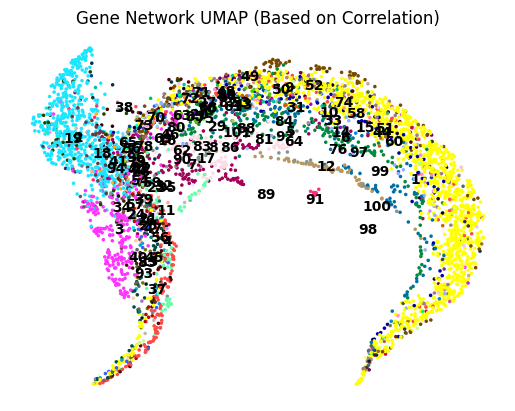

In [64]:
# 1. PCA
# We use arpack solver. If you have many genes, this reduces noise.
sc.tl.pca(adata_genes, svd_solver='arpack')

# 2. Neighbors
# Identify genes with similar correlation profiles
sc.pp.neighbors(adata_genes, n_neighbors=15, n_pcs=20)

# 3. UMAP
sc.tl.umap(adata_genes)

# 4. Plot
# legend_loc='on data' puts the label on top of the cluster
sc.pl.umap(adata_genes, 
           color='Infomap_Module', 
           title='Gene Network UMAP (Based on Correlation)',
           legend_loc='on data',
           frameon=False)

In [65]:
# Assuming 'junk_id' is the ID of your large module
junk_id = 1 
junk_genes = adata_genes.var_names[im_modules == junk_id]

# 1. Check size
print(f"Module size: {len(junk_genes)} genes")

# 2. Check for Ribosomal (RPS/RPL) or Mitochondrial (MT-) genes
ribo_count = junk_genes.str.startswith(('RPS', 'RPL')).sum()
mito_count = junk_genes.str.startswith('MT-').sum()

print(f"Ribosomal genes: {ribo_count}")
print(f"Mitochondrial genes: {mito_count}")

# 3. Print the top 20 genes to eyeball
print(junk_genes[:20].tolist())

Module size: 1363 genes
Ribosomal genes: 3
Mitochondrial genes: 0
['FIRRM', 'HS3ST1', 'ICA1', 'CASP10', 'PLXND1', 'CALCR', 'SKAP2', 'MSL3', 'ABCB4', 'ITGAL', 'CEACAM21', 'GAS7', 'CYTH3', 'TRAF3IP3', 'MLXIPL', 'STAB1', 'CD4', 'BTK', 'LDAF1', 'ERCC1']


In [ ]:
import numpy as np
from scipy import sparse
import pandas as pd

# Get the list of unique modules from your dictionary
unique_modules = sorted(np.unique(adata_genes.obs['Infomap_Module'].astype(int)))
print(f'Found {len(unique_modules)} unique modules')
homogeneity_scores = {}

size_thresh = 10

module_means = {}
modules = im_modules.astype(str)

for mod_id in unique_modules:
    # 1. Get the list of genes for this module
    # Filter to ensure these genes exist in your current adata object
    module_mask = im_modules == mod_id

    if np.sum(module_mask) < size_thresh:
        # set label to Unassigned
        modules[module_mask] = 'Unassigned'
        continue


    # 2. Subset the data to these genes
    # This creates a View (lightweight)
    gene_subset = adata_hvg[:, module_mask]
    
    # 3. Calculate the mean expression across genes (axis=1)
    # Handle sparse matrix explicitly to be safe
    if sparse.issparse(gene_subset.X):
        # .mean() on sparse returns a matrix, .A1 flattens it to a 1D array
        mean_vals = gene_subset.X.mean(axis=1).A1
    else:
        mean_vals = np.mean(gene_subset.X, axis=1)
        
    module_means[mod_id] = mean_vals
    
    # compute homogeneity - how much variance is accounted for
    # by the first principal component of the genes in the module
    
    # First scale the data (Z-score)
    # PCA requires unit variance so high-expression genes don't dominate
    # This densifies the matrix, which is why we subsampled first
    sc.pp.scale(gene_subset, max_value=10)
    
    # 3. Run PCA (we only need the 1st component)
    sc.tl.pca(gene_subset, n_comps=1)
    
    # 4. Extract the variance ratio
    # 'variance_ratio' sums to 1.0 across all PCs
    var_explained = gene_subset.uns['pca']['variance_ratio'][0]
    homogeneity_scores[mod_id] = var_explained



    module_means_df = pd.DataFrame(module_means, index=adata_hvg.obs_names)

unique_modules_str = [str(mod) for mod in np.unique(modules)]
adata_hvg.var['Infomap_Module'] = pd.Categorical(
    [str(mod) for mod in modules],
    categories=unique_modules_str,
    ordered=True
)


# Check the results
module_means_df.head()

Found 101 unique modules


/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/poldrack/.local/share/uv/python/cpython-3.12.0-macos-aarch64-none/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/poldrack/.local/share/uv/python/cpython-3.12.0-macos-aarch64-none/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  

NameError: name 'unique_modules_str' is not defined

In [78]:
homogeneity_scores

{np.int64(1): np.float64(0.153287518918392),
 np.int64(2): np.float64(0.028535903271219524),
 np.int64(3): np.float64(0.10507818167472564),
 np.int64(4): np.float64(0.18204036861133976),
 np.int64(5): np.float64(0.09365783653853473),
 np.int64(6): np.float64(0.12049901607044601),
 np.int64(7): np.float64(0.08027450194492235),
 np.int64(8): np.float64(0.07985241264209553),
 np.int64(9): np.float64(0.11437265519259121),
 np.int64(10): np.float64(0.11232624066742267),
 np.int64(11): np.float64(0.14764986141661363),
 np.int64(12): np.float64(0.188629706195819),
 np.int64(13): np.float64(0.20069557300469867),
 np.int64(14): np.float64(0.13218589671715883),
 np.int64(15): np.float64(0.1647411007842941),
 np.int64(16): np.float64(0.12795235576977812),
 np.int64(17): np.float64(0.09329584234553662),
 np.int64(18): np.float64(0.04782506597336753),
 np.int64(19): np.float64(0.06437803415291381),
 np.int64(20): np.float64(0.10680724751783124),
 np.int64(21): np.float64(0.17596374173565282),
 np.i

In [85]:
np.unique(adata_hvg.obs['Cognitive status'])

array(['Dementia', 'No dementia', 'Reference'], dtype=object)

In [91]:
# create a statmodels model predicting adata_hvg.obs['Cognitive status'] from the module means

import statsmodels.api as sm

X = module_means_df.values
X = sm.add_constant(X)
y = adata_hvg.obs['Cognitive status'].astype('category').cat.codes.values

# drop values with cognitive status = "Reference"
mask = adata_hvg.obs['Cognitive status'] != 'Reference'
X = X[mask, :]
y = y[mask]

model = sm.Logit(
    endog=y,
    exog=X,
    data=pd.concat([adata_hvg.obs, module_means_df], axis=1)
).fit() 
model.summary()

# compute prediction accuracy
preds = model.predict(X)
pred_labels = (preds > 0.5).astype(int)
accuracy = (pred_labels == y).mean()
print(f'Prediction accuracy: {accuracy:.3f}')


Optimization terminated successfully.
         Current function value: 0.568460
         Iterations 6
Prediction accuracy: 0.715


/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)
/Users/poldrack/Dropbox/code/bettercode/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


In [99]:
np.unique(adata_hvg.obs['donor_id']).shape

(38,)

In [109]:
# create a model to predict age_group from the module means

y = adata_hvg.obs['age_group'].values

X = module_means_df.values
X = sm.add_constant(X)

model = sm.MixedLM(
    endog=y,
    exog=X,
    groups=adata_hvg.obs['donor_id']
).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: y          
No. Observations: 58654   Method:             REML       
No. Groups:       38      Scale:              0.0000     
Min. group size:  668     Log-Likelihood:     660473.4969
Max. group size:  2980    Converged:          Yes        
Mean group size:  1543.5                                 
---------------------------------------------------------
             Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------
const        85.542    0.083 1030.907 0.000 85.380 85.705
x1            0.000    0.000    0.000 1.000 -0.000  0.000
x2            0.000    0.000    0.000 1.000 -0.000  0.000
x3           -0.000    0.000   -0.000 1.000 -0.000  0.000
x4           -0.000    0.000   -0.000 1.000 -0.000  0.000
x5           -0.000    0.000   -0.000 1.000 -0.000  0.000
x6            0.000    0.000    0.000 1.000 -0.000  0.000
x7            0.000    0.000    0.000 1.000 -0.000  0.000
x8            0.000    0.000    0.000 1.000 -0.000  0.000
x9           -0.000    0.000   -0.000 1.000 -0.000  0.000
x10           0.000    0.000    0.000 1.000 -0.000  0.000
x11           0.000    0.000    0.000 1.000 -0.000  0.000
x12          -0.000    0.000   -0.000 1.000 -0.000  0.000
x13           0.000    0.000    0.000 1.000 -0.000  0.000
x14          -0.000    0.000   -0.000 1.000 -0.000  0.000
x15           0.000    0.000    0.000 1.000 -0.000  0.000
x16          -0.000    0.000   -0.000 1.000 -0.000  0.000
x17          -0.000    0.000   -0.000 1.000 -0.000  0.000
x18          -0.000    0.000   -0.000 1.000 -0.000  0.000
x19           0.000    0.000    0.000 1.000 -0.000  0.000
x20          -0.000    0.000   -0.000 1.000 -0.000  0.000
x21           0.000    0.000    0.000 1.000 -0.000  0.000
x22           0.000    0.000    0.000 1.000 -0.000  0.000
x23          -0.000    0.000   -0.000 1.000 -0.000  0.000
x24           0.000    0.000    0.000 1.000 -0.000  0.000
x25          -0.000    0.000   -0.000 1.000 -0.000  0.000
x26           0.000    0.000    0.000 1.000 -0.000  0.000
x27          -0.000    0.000   -0.000 1.000 -0.000  0.000
x28           0.000    0.000    0.000 1.000 -0.000  0.000
x29          -0.000    0.000   -0.000 1.000 -0.000  0.000
x30          -0.000    0.000   -0.000 1.000 -0.000  0.000
x31           0.000    0.000    0.000 1.000 -0.000  0.000
x32           0.000    0.000    0.000 1.000 -0.000  0.000
x33           0.000    0.000    0.000 1.000 -0.000  0.000
x34           0.000    0.000    0.000 1.000 -0.000  0.000
x35          -0.000    0.000   -0.000 1.000 -0.000  0.000
x36          -0.000    0.000   -0.000 1.000 -0.000  0.000
x37           0.000    0.000    0.000 1.000 -0.000  0.000
x38           0.000    0.000    0.000 1.000 -0.000  0.000
x39          -0.000    0.000   -0.000 1.000 -0.000  0.000
x40          -0.000    0.000   -0.000 1.000 -0.000  0.000
x41          -0.000    0.000   -0.000 1.000 -0.000  0.000
x42          -0.000    0.000   -0.000 1.000 -0.000  0.000
x43           0.000    0.000    0.000 1.000 -0.000  0.000
x44          -0.000    0.000   -0.000 1.000 -0.000  0.000
x45          -0.000    0.000   -0.000 1.000 -0.000  0.000
x46           0.000    0.000    0.000 1.000 -0.000  0.000
x47           0.000    0.000    0.000 1.000 -0.000  0.000
x48           0.000    0.000    0.000 1.000 -0.000  0.000
x49          -0.000    0.000   -0.000 1.000 -0.000  0.000
x50          -0.000    0.000   -0.000 1.000 -0.000  0.000
x51           0.000    0.000    0.000 1.000 -0.000  0.000
x52          -0.000    0.000   -0.000 1.000 -0.000  0.000
x53           0.000    0.000    0.000 1.000 -0.000  0.000
x54          -0.000    0.000   -0.000 1.000 -0.000  0.000
x55           0.000    0.000    0.000 1.000 -0.000  0.000
x56           0.000    0.000    0.000 1.000 -0.000  0.000
x57           0.0